In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy.stats import ttest_ind

In [74]:
# File path
path_to_tas = "/hpx/richar/tas/ERA5-Land_tas_daily_{year}.nc"

# User input for time periods
#print("Enter the first time period:")
start_year_1 = 1980  # int(input("Start year (e.g., 1980): "))
end_year_1 = 1990  # int(input("End year (e.g., 1990): "))

#print("Enter the second time period:")
start_year_2 = 2000  # int(input("Start year (e.g., 2000): "))
end_year_2 = 2010  # int(input("End year (e.g., 2010): "))

# Bounding box for Europe
europe_lon_min, europe_lon_max = -25, 45
europe_lat_min, europe_lat_max = 35, 70

In [58]:
# Function to calculate High risk days (ARI>0.50) for all years in the given period
def calculate_ARI_days(start_year, end_year):
    # ARI_days_list = []  # Store ARI days for each year

    infiles = [
        path_to_tas.format(year=year) for year in range(start_year, end_year + 1)
    ]

    tas_ds = xr.open_mfdataset(infiles, concat_dim="time", combine="nested")
    tas = tas_ds["tas"] - 273.15  # Convert from Kelvin to Celsius

    # Mask non-European regions
    tas_day = tas.where(
        (tas["longitude"] >= europe_lon_min)
        & (tas["longitude"] <= europe_lon_max)
        & (tas["latitude"] >= europe_lat_min)
        & (tas["latitude"] <= europe_lat_max),
        drop=True,
    )

    # Compute ARI days per year
    ARI_days_year = xr.zeros_like(
        tas.isel(time=0)
    )  # Initializing a 2D array (latitude x longitude) filled with zeros
    # to store the count of days where ARI > 0.50 for each grid cell

    # for day in range(len(tas['time'])):
    # tas_day = tas.isel(time=day)

    # Compute SPORULATION
    Teq_spor = (tas_day - 5) / (45 - 5)
    SPOR = xr.where(
        (Teq_spor > 0) & (Teq_spor < 1),
        5.28200632 * Teq_spor**2.05221609 * (1 - Teq_spor) ** 0.97677772,
        0,
    )

    # Compute GROWTH
    Teq_grow = (tas_day - 5) / (48 - 5)
    GROW_T = xr.where(
        (Teq_grow > 0) & (Teq_grow < 1),
        (5.98426163 * Teq_grow**1.70408086 * (1 - Teq_grow)) ** 1.42921131,
        0,
    )

    # Compute AFLATOXIN PRODUCTION
    Teq_afla = (tas_day - 10) / (47 - 10)
    AFLA = xr.where(
        (Teq_afla > 0) & (Teq_afla < 1),
        (4.84 * Teq_afla**1.32 * (1 - Teq_afla)) ** 5.59,
        0,
    )

    # Compute daily ARI
    ARI_day = SPOR * GROW_T * AFLA

    # Count days where ARI > 0.50
    ARI_days_year = (ARI_day > 0.50)*1.  # .sum('time')

    # ARI_days_list.append(ARI_days_year)

    return ARI_days_year  # xr.concat(ARI_days_list, dim='time')

In [59]:
# Compute ARI days for both periods
ARI_days_1 = calculate_ARI_days(start_year_1, end_year_1).load()
ARI_days_2 = calculate_ARI_days(start_year_2, end_year_2).load()

In [ ]:
diff = ARI_days_2.sum("time") - ARI_days_1.sum("time")
diff.attrs['units'] = 'number of days'
diff.attrs['long_name'] = 'HRD'

In [64]:
_, p_values = ttest_ind(
    ARI_days_1.values, ARI_days_2.values, equal_var=False
)  # , nan_policy='omit')

In [65]:
pv_da = xr.DataArray(p_values.T, coords=ARI_days_1[0].reset_coords().coords)
pv_da

<xarray.DataArray (longitude: 561, latitude: 351)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.39624488, 0.51721126,
        0.54861651],
       [       nan,        nan,        nan, ..., 0.9599282 , 0.41125678,
        0.53429748],
       [       nan,        nan,        nan, ..., 0.76231953, 0.46938222,
        0.42614834]])
Coordinates:
  * longitude  (longitude) float64 -11.0 -10.9 -10.8 -10.7 ... 44.8 44.9 45.0
  * latitude   (latitude) float64 70.0 69.9 69.8 69.7 ... 35.3 35.2 35.1 35.0

Text(0.5, 1.0, 'Statistically Significant Difference in High Risk Days (HRD) \n1980-1990 vs 2000-2010')

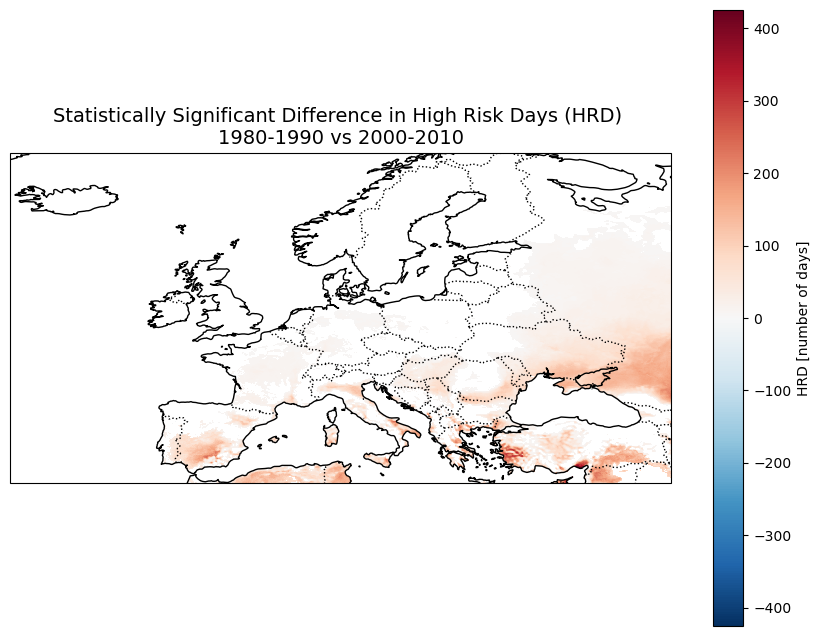

In [81]:
projection = ccrs.PlateCarree()
p = diff.where(pv_da < 0.05).plot(size = 8, transform=ccrs.PlateCarree(), subplot_kws=dict(projection=projection))

ax = p.axes
ax.set_extent([-25, 45, 35, 70], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black')
ax.set_title(f'Statistically Significant Difference in High Risk Days (HRD) \n{start_year_1}-{end_year_1} vs {start_year_2}-{end_year_2}', fontsize=14)